In [1]:
from io import open
import glob
import os


def findFiles(path):
    return glob.glob(path)


print(findFiles("data/names/*.txt"))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


print(unicodeToAscii("Ślusàrski"))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines["Russian"][:5])

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski
['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']


In [2]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print(letterToTensor("J"))


print(lineToTensor("Jones").size())
# print(lineToTensor("Jones"))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [3]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [4]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9751, -2.8526, -2.8298, -2.9267, -2.9574, -2.8220, -2.8530, -2.8671,
         -2.8876, -2.8870, -2.8609, -2.8840, -2.9012, -2.8985, -2.8971, -2.9491,
         -2.8660, -2.9270]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


print(categoryFromOutput(output))

import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category =", category, "/ line =", line)


('French', 5)
category = Irish / line = O'Sullivan
category = Italian / line = Nicotera
category = Russian / line = Beizerov
category = Chinese / line = Bai
category = English / line = Gray
category = Chinese / line = Shaw
category = Greek / line = Kanavos
category = Spanish / line = Oliver
category = Russian / line = Isaichikov
category = Czech / line = Kafka


In [25]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

rnn = RNN(n_letters, n_hidden, n_categories)
loss_fn = nn.NLLLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # model pred
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    return output, loss.item()


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print(
            "%d %d%% (%s) LOSS: %.4f %s / %s %s"
            % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct)
        )

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) LOSS: 1.2391 Omura / Japanese ✓
10000 10% (0m 19s) LOSS: 4.2035 Aonghuis / Greek ✗ (Irish)
15000 15% (0m 30s) LOSS: 1.9049 Zee / Chinese ✗ (Dutch)
20000 20% (0m 41s) LOSS: 0.8637 Andrysiak / Polish ✓
25000 25% (0m 52s) LOSS: 1.7165 Granger / German ✗ (French)
30000 30% (1m 2s) LOSS: 0.5436 Lieu / Vietnamese ✓
35000 35% (1m 13s) LOSS: 1.4713 Wang / Scottish ✗ (Korean)
40000 40% (1m 24s) LOSS: 0.4920 Sabbag / Arabic ✓
45000 45% (1m 36s) LOSS: 0.1153 Glynatsis / Greek ✓
50000 50% (1m 48s) LOSS: 0.3172 Doan / Vietnamese ✓
55000 55% (2m 3s) LOSS: 0.0815 Takashi / Japanese ✓
60000 60% (2m 16s) LOSS: 0.6044 Nassar / Arabic ✓
65000 65% (2m 28s) LOSS: 0.7949 Foong / Chinese ✓
70000 70% (2m 41s) LOSS: 0.9453 Dreher / German ✓
75000 75% (2m 52s) LOSS: 0.0518 Veronesi / Italian ✓
80000 80% (3m 5s) LOSS: 0.0145 Xiao / Chinese ✓
85000 85% (3m 17s) LOSS: 1.1405 Morales / Portuguese ✗ (Spanish)
90000 90% (3m 30s) LOSS: 0.7987 Kumiega / Polish ✓
95000 95% (3m 43s) LOSS: 0.3494 Palmeiro 

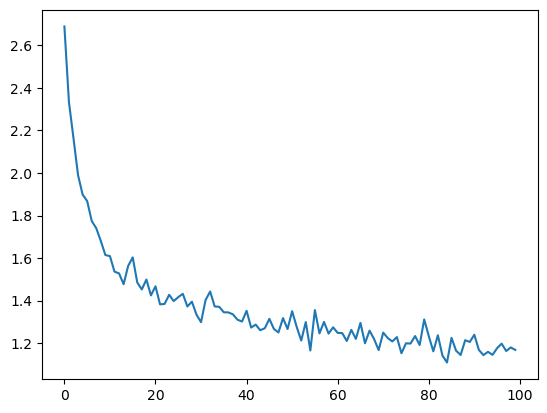

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\saegl\AppData\Local\Temp\ipykernel_18068\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\saegl\AppData\Local\Temp\ipykernel_18068\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


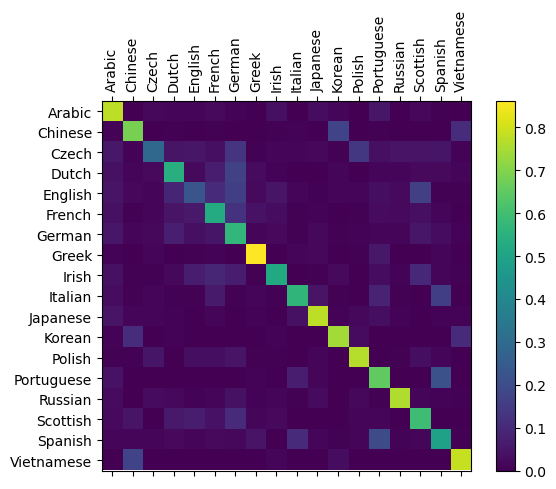

In [27]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [28]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Alisher')
predict('Saegl')


> Dovesky
(-0.33) Russian
(-1.66) Czech
(-3.22) English

> Jackson
(-0.03) Scottish
(-4.43) English
(-4.61) German

> Satoshi
(-0.78) Japanese
(-0.99) Arabic
(-2.26) Italian

> Alisher
(-0.82) German
(-1.46) Dutch
(-2.09) Arabic

> Saegl
(-1.75) Dutch
(-1.81) German
(-2.03) Irish
